# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [39]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

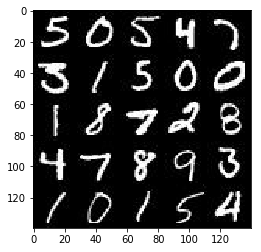

In [40]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

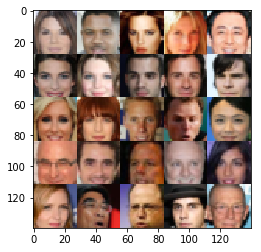

In [41]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [43]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [44]:
# Note: Added alpha and keep_prob by myself
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.75):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with (tf.variable_scope('discriminator', reuse=reuse)):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        drop2 = tf.nn.dropout(x2, keep_prob)
        bn2 = tf.layers.batch_normalization(drop2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        drop3 = tf.nn.dropout(x3, keep_prob)
        bn3 = tf.layers.batch_normalization(drop3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [45]:
# Note: Din't add keep_prob with a dropout layer here.
# Also, try with xavier initialization.
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with (tf.variable_scope('generator', reuse=not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [46]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    # As per the suggestion in the review, smoothing the "input_real" by *0.9.
    # Hopefully this improves the performance of the discriminator.
    d_model_real, d_logits_real = discriminator(input_real*0.9, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    training_vars = tf.trainable_variables()
    d_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in training_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train \
                            .AdamOptimizer(learning_rate, beta1=beta1) \
                            .minimize(d_loss, var_list=d_vars)
                
        g_train_opt = tf.train \
                            .AdamOptimizer(learning_rate, beta1=beta1) \
                            .minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

Example train losses when using 1 step each for G and D.

```
Epoch 1/1... Discriminator Loss: 0.2912... Generator Loss: 2.8536
Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 7.6920
Epoch 1/1... Discriminator Loss: 0.3247... Generator Loss: 2.1167
Epoch 1/1... Discriminator Loss: 0.0915... Generator Loss: 5.7633
Epoch 1/1... Discriminator Loss: 0.2157... Generator Loss: 10.8242
Epoch 1/1... Discriminator Loss: 0.0729... Generator Loss: 6.1633
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 1.7345
Epoch 1/1... Discriminator Loss: 2.2379... Generator Loss: 0.3640
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 5.0067
Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 4.0127
```

In [49]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          show_every=100, print_every=10):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Generator output is a tanh, ranging between -1 and +1, where as batch_images are
                # ranging between -0.5 to 0.5 as specified at the start. Hence, normalize real images
                # from -1 to +1 (Suggestion provided in the review)
                batch_images = batch_images * 2
                steps += 1
                
                # Get a sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers for discriminator and generator.
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                # As per one of the hacks mentioned at https://github.com/soumith/ganhacks
                # Adding an extra traing step for generator because generator loss is getting very high
                # when running 1 step each for D and G. This additional step will help generator 
                # catch up with discriminator.
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                # Printing loss for every 10 steps (print_every)
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # Show the generator output for every 100 steps (show_every).
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4... Discriminator Loss: 1.8364... Generator Loss: 0.4042
Epoch 1/4... Discriminator Loss: 1.7613... Generator Loss: 0.6622
Epoch 1/4... Discriminator Loss: 1.9309... Generator Loss: 0.5859
Epoch 1/4... Discriminator Loss: 1.7482... Generator Loss: 0.7270
Epoch 1/4... Discriminator Loss: 1.7181... Generator Loss: 0.6056
Epoch 1/4... Discriminator Loss: 1.6135... Generator Loss: 0.8387
Epoch 1/4... Discriminator Loss: 1.5240... Generator Loss: 0.8431
Epoch 1/4... Discriminator Loss: 1.6314... Generator Loss: 0.7092
Epoch 1/4... Discriminator Loss: 1.4604... Generator Loss: 0.7384
Epoch 1/4... Discriminator Loss: 1.4028... Generator Loss: 0.9527


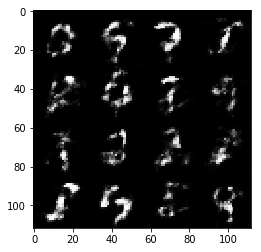

Epoch 1/4... Discriminator Loss: 1.4002... Generator Loss: 1.0014
Epoch 1/4... Discriminator Loss: 1.5754... Generator Loss: 0.8292
Epoch 1/4... Discriminator Loss: 1.4531... Generator Loss: 1.1266
Epoch 1/4... Discriminator Loss: 1.5672... Generator Loss: 0.9471
Epoch 1/4... Discriminator Loss: 1.4776... Generator Loss: 0.6885
Epoch 1/4... Discriminator Loss: 1.5405... Generator Loss: 0.8302
Epoch 1/4... Discriminator Loss: 1.4641... Generator Loss: 0.7150
Epoch 1/4... Discriminator Loss: 1.5504... Generator Loss: 0.8771
Epoch 1/4... Discriminator Loss: 1.4612... Generator Loss: 0.8672
Epoch 1/4... Discriminator Loss: 1.4909... Generator Loss: 0.9439


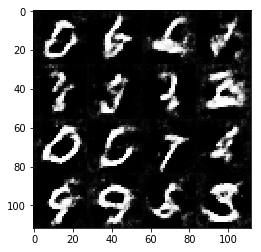

Epoch 1/4... Discriminator Loss: 1.5167... Generator Loss: 1.2719
Epoch 1/4... Discriminator Loss: 1.5247... Generator Loss: 1.0332
Epoch 1/4... Discriminator Loss: 1.3165... Generator Loss: 0.9511
Epoch 1/4... Discriminator Loss: 1.3104... Generator Loss: 0.9858
Epoch 1/4... Discriminator Loss: 1.4209... Generator Loss: 0.9398
Epoch 1/4... Discriminator Loss: 1.3491... Generator Loss: 0.9309
Epoch 1/4... Discriminator Loss: 1.5268... Generator Loss: 1.2582
Epoch 1/4... Discriminator Loss: 1.2433... Generator Loss: 0.9821
Epoch 1/4... Discriminator Loss: 1.4174... Generator Loss: 1.2481
Epoch 1/4... Discriminator Loss: 1.5447... Generator Loss: 1.5228


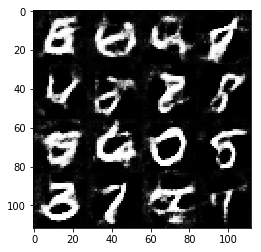

Epoch 1/4... Discriminator Loss: 1.3907... Generator Loss: 1.2294
Epoch 1/4... Discriminator Loss: 1.2608... Generator Loss: 1.0531
Epoch 1/4... Discriminator Loss: 1.2245... Generator Loss: 0.9710
Epoch 1/4... Discriminator Loss: 1.2772... Generator Loss: 0.8731
Epoch 1/4... Discriminator Loss: 1.5977... Generator Loss: 0.3576
Epoch 1/4... Discriminator Loss: 1.2301... Generator Loss: 2.1664
Epoch 1/4... Discriminator Loss: 1.1981... Generator Loss: 0.7615
Epoch 1/4... Discriminator Loss: 1.0222... Generator Loss: 0.8533
Epoch 1/4... Discriminator Loss: 1.3494... Generator Loss: 2.0726
Epoch 1/4... Discriminator Loss: 1.0928... Generator Loss: 0.7961


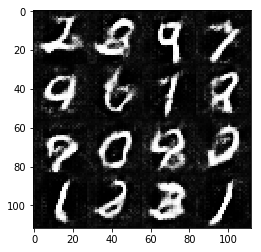

Epoch 1/4... Discriminator Loss: 1.1913... Generator Loss: 1.8654
Epoch 1/4... Discriminator Loss: 0.9208... Generator Loss: 0.6795
Epoch 1/4... Discriminator Loss: 1.6720... Generator Loss: 2.4458
Epoch 1/4... Discriminator Loss: 2.1415... Generator Loss: 3.0500
Epoch 1/4... Discriminator Loss: 0.8756... Generator Loss: 1.5392
Epoch 1/4... Discriminator Loss: 1.3038... Generator Loss: 1.2171
Epoch 2/4... Discriminator Loss: 1.5435... Generator Loss: 1.0384
Epoch 2/4... Discriminator Loss: 1.6260... Generator Loss: 0.2567
Epoch 2/4... Discriminator Loss: 1.5568... Generator Loss: 2.0709
Epoch 2/4... Discriminator Loss: 0.9860... Generator Loss: 0.7557


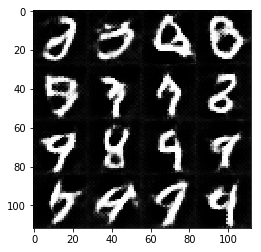

Epoch 2/4... Discriminator Loss: 1.0725... Generator Loss: 1.6437
Epoch 2/4... Discriminator Loss: 1.0511... Generator Loss: 2.1298
Epoch 2/4... Discriminator Loss: 1.4165... Generator Loss: 0.7292
Epoch 2/4... Discriminator Loss: 1.3211... Generator Loss: 0.6938
Epoch 2/4... Discriminator Loss: 1.3315... Generator Loss: 0.9431
Epoch 2/4... Discriminator Loss: 1.2850... Generator Loss: 0.8951
Epoch 2/4... Discriminator Loss: 1.4108... Generator Loss: 0.9334
Epoch 2/4... Discriminator Loss: 1.3795... Generator Loss: 0.9034
Epoch 2/4... Discriminator Loss: 1.3762... Generator Loss: 1.0166
Epoch 2/4... Discriminator Loss: 1.2597... Generator Loss: 0.8683


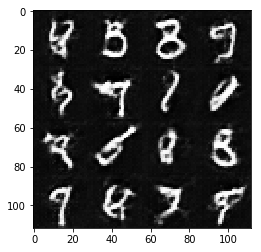

Epoch 2/4... Discriminator Loss: 1.2633... Generator Loss: 0.8797
Epoch 2/4... Discriminator Loss: 1.2443... Generator Loss: 0.9143
Epoch 2/4... Discriminator Loss: 1.2265... Generator Loss: 0.9473
Epoch 2/4... Discriminator Loss: 1.2952... Generator Loss: 1.3737
Epoch 2/4... Discriminator Loss: 1.0605... Generator Loss: 1.3319
Epoch 2/4... Discriminator Loss: 1.3181... Generator Loss: 0.7319
Epoch 2/4... Discriminator Loss: 1.4361... Generator Loss: 0.8763
Epoch 2/4... Discriminator Loss: 1.2357... Generator Loss: 0.8133
Epoch 2/4... Discriminator Loss: 1.2347... Generator Loss: 0.9888
Epoch 2/4... Discriminator Loss: 1.3093... Generator Loss: 0.8025


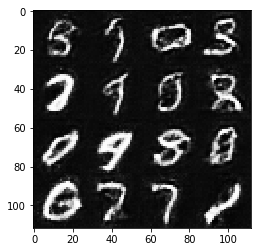

Epoch 2/4... Discriminator Loss: 1.6351... Generator Loss: 0.9801
Epoch 2/4... Discriminator Loss: 1.4842... Generator Loss: 1.0788
Epoch 2/4... Discriminator Loss: 1.3494... Generator Loss: 0.7524
Epoch 2/4... Discriminator Loss: 1.3839... Generator Loss: 0.9788
Epoch 2/4... Discriminator Loss: 1.3542... Generator Loss: 0.9444
Epoch 2/4... Discriminator Loss: 1.3502... Generator Loss: 0.8721
Epoch 2/4... Discriminator Loss: 1.2224... Generator Loss: 0.9778
Epoch 2/4... Discriminator Loss: 1.0510... Generator Loss: 1.4047
Epoch 2/4... Discriminator Loss: 1.4106... Generator Loss: 0.8361
Epoch 2/4... Discriminator Loss: 1.2606... Generator Loss: 1.4565


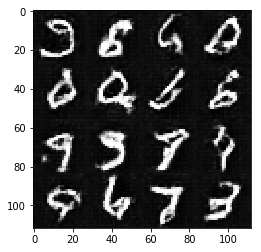

Epoch 2/4... Discriminator Loss: 1.2674... Generator Loss: 0.8756
Epoch 2/4... Discriminator Loss: 1.2061... Generator Loss: 0.8072
Epoch 2/4... Discriminator Loss: 1.0069... Generator Loss: 1.2080
Epoch 2/4... Discriminator Loss: 1.2133... Generator Loss: 0.7558
Epoch 2/4... Discriminator Loss: 1.3005... Generator Loss: 1.1057
Epoch 2/4... Discriminator Loss: 1.3528... Generator Loss: 0.8409
Epoch 2/4... Discriminator Loss: 1.3155... Generator Loss: 0.8345
Epoch 2/4... Discriminator Loss: 1.2538... Generator Loss: 0.8571
Epoch 2/4... Discriminator Loss: 1.2729... Generator Loss: 0.9706
Epoch 2/4... Discriminator Loss: 1.2703... Generator Loss: 1.1245


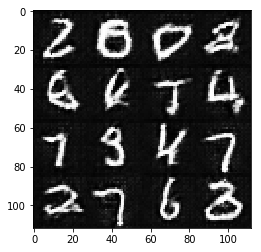

Epoch 2/4... Discriminator Loss: 1.2856... Generator Loss: 0.7867
Epoch 2/4... Discriminator Loss: 1.2423... Generator Loss: 0.9411
Epoch 2/4... Discriminator Loss: 1.1822... Generator Loss: 0.9094
Epoch 3/4... Discriminator Loss: 1.5464... Generator Loss: 0.7389
Epoch 3/4... Discriminator Loss: 1.3136... Generator Loss: 0.9133
Epoch 3/4... Discriminator Loss: 1.1471... Generator Loss: 0.8979
Epoch 3/4... Discriminator Loss: 1.2336... Generator Loss: 0.6799
Epoch 3/4... Discriminator Loss: 1.2108... Generator Loss: 1.0728
Epoch 3/4... Discriminator Loss: 1.2515... Generator Loss: 1.1053
Epoch 3/4... Discriminator Loss: 1.3612... Generator Loss: 1.0980


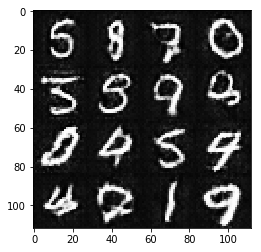

Epoch 3/4... Discriminator Loss: 1.2252... Generator Loss: 1.0183
Epoch 3/4... Discriminator Loss: 1.3889... Generator Loss: 0.6036
Epoch 3/4... Discriminator Loss: 1.3853... Generator Loss: 0.7890
Epoch 3/4... Discriminator Loss: 1.2546... Generator Loss: 0.8040
Epoch 3/4... Discriminator Loss: 1.3332... Generator Loss: 0.8494
Epoch 3/4... Discriminator Loss: 1.4458... Generator Loss: 1.0895
Epoch 3/4... Discriminator Loss: 1.2238... Generator Loss: 0.7890
Epoch 3/4... Discriminator Loss: 1.3564... Generator Loss: 0.6846
Epoch 3/4... Discriminator Loss: 1.1601... Generator Loss: 1.2719
Epoch 3/4... Discriminator Loss: 1.1427... Generator Loss: 1.0339


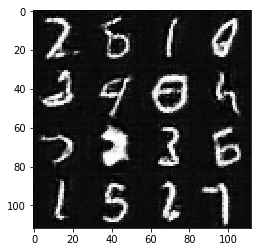

Epoch 3/4... Discriminator Loss: 1.2656... Generator Loss: 1.5408
Epoch 3/4... Discriminator Loss: 1.2426... Generator Loss: 0.8381
Epoch 3/4... Discriminator Loss: 1.3337... Generator Loss: 1.0666
Epoch 3/4... Discriminator Loss: 1.3557... Generator Loss: 0.9847
Epoch 3/4... Discriminator Loss: 1.2617... Generator Loss: 0.7492
Epoch 3/4... Discriminator Loss: 1.2874... Generator Loss: 0.9565
Epoch 3/4... Discriminator Loss: 1.1509... Generator Loss: 0.9418
Epoch 3/4... Discriminator Loss: 1.0477... Generator Loss: 0.9679
Epoch 3/4... Discriminator Loss: 1.2155... Generator Loss: 1.0275
Epoch 3/4... Discriminator Loss: 1.2069... Generator Loss: 1.0748


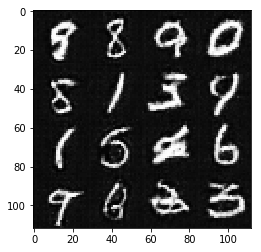

Epoch 3/4... Discriminator Loss: 1.2424... Generator Loss: 0.9650
Epoch 3/4... Discriminator Loss: 1.2007... Generator Loss: 0.9440
Epoch 3/4... Discriminator Loss: 1.6128... Generator Loss: 1.0557
Epoch 3/4... Discriminator Loss: 1.0798... Generator Loss: 1.1289
Epoch 3/4... Discriminator Loss: 1.2073... Generator Loss: 1.1416
Epoch 3/4... Discriminator Loss: 1.2566... Generator Loss: 0.9447
Epoch 3/4... Discriminator Loss: 1.1765... Generator Loss: 1.0670
Epoch 3/4... Discriminator Loss: 1.3191... Generator Loss: 1.1738
Epoch 3/4... Discriminator Loss: 1.3471... Generator Loss: 0.7617
Epoch 3/4... Discriminator Loss: 1.3489... Generator Loss: 0.8744


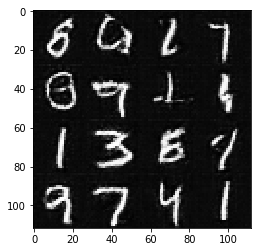

Epoch 3/4... Discriminator Loss: 1.2462... Generator Loss: 0.9009
Epoch 3/4... Discriminator Loss: 1.1915... Generator Loss: 1.0311
Epoch 3/4... Discriminator Loss: 1.2562... Generator Loss: 0.8968
Epoch 3/4... Discriminator Loss: 1.2664... Generator Loss: 0.8879
Epoch 3/4... Discriminator Loss: 1.1167... Generator Loss: 1.0054
Epoch 3/4... Discriminator Loss: 1.1115... Generator Loss: 1.1007
Epoch 3/4... Discriminator Loss: 1.2942... Generator Loss: 0.7959
Epoch 3/4... Discriminator Loss: 1.3719... Generator Loss: 0.8180
Epoch 3/4... Discriminator Loss: 1.3025... Generator Loss: 0.8687
Epoch 3/4... Discriminator Loss: 1.1086... Generator Loss: 0.8758


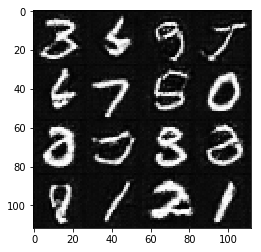

Epoch 4/4... Discriminator Loss: 1.1522... Generator Loss: 1.1397
Epoch 4/4... Discriminator Loss: 1.1613... Generator Loss: 0.9536
Epoch 4/4... Discriminator Loss: 1.2239... Generator Loss: 1.0631
Epoch 4/4... Discriminator Loss: 1.3356... Generator Loss: 0.8846
Epoch 4/4... Discriminator Loss: 1.3071... Generator Loss: 0.7876
Epoch 4/4... Discriminator Loss: 1.2250... Generator Loss: 0.9188
Epoch 4/4... Discriminator Loss: 1.3493... Generator Loss: 0.7888
Epoch 4/4... Discriminator Loss: 1.2921... Generator Loss: 0.8684
Epoch 4/4... Discriminator Loss: 1.2905... Generator Loss: 0.6105
Epoch 4/4... Discriminator Loss: 1.1806... Generator Loss: 1.0209


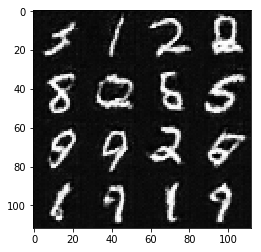

Epoch 4/4... Discriminator Loss: 1.1469... Generator Loss: 0.8114
Epoch 4/4... Discriminator Loss: 1.3409... Generator Loss: 0.6454
Epoch 4/4... Discriminator Loss: 1.3318... Generator Loss: 0.8335
Epoch 4/4... Discriminator Loss: 1.1796... Generator Loss: 0.9173
Epoch 4/4... Discriminator Loss: 1.3149... Generator Loss: 0.7499
Epoch 4/4... Discriminator Loss: 1.2160... Generator Loss: 0.7769
Epoch 4/4... Discriminator Loss: 1.2640... Generator Loss: 0.8458
Epoch 4/4... Discriminator Loss: 1.3960... Generator Loss: 0.7754
Epoch 4/4... Discriminator Loss: 1.2865... Generator Loss: 0.8830
Epoch 4/4... Discriminator Loss: 1.2450... Generator Loss: 0.8807


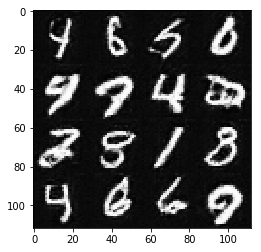

Epoch 4/4... Discriminator Loss: 1.2685... Generator Loss: 1.0694
Epoch 4/4... Discriminator Loss: 1.1361... Generator Loss: 1.3758
Epoch 4/4... Discriminator Loss: 1.2717... Generator Loss: 1.0465
Epoch 4/4... Discriminator Loss: 1.3399... Generator Loss: 0.8194
Epoch 4/4... Discriminator Loss: 1.1543... Generator Loss: 0.9470
Epoch 4/4... Discriminator Loss: 1.2854... Generator Loss: 1.0604
Epoch 4/4... Discriminator Loss: 1.2340... Generator Loss: 0.9026
Epoch 4/4... Discriminator Loss: 1.3717... Generator Loss: 0.9587
Epoch 4/4... Discriminator Loss: 1.2015... Generator Loss: 0.8879
Epoch 4/4... Discriminator Loss: 1.1860... Generator Loss: 1.1359


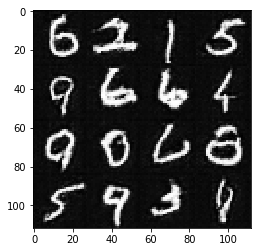

Epoch 4/4... Discriminator Loss: 1.3419... Generator Loss: 0.8190
Epoch 4/4... Discriminator Loss: 1.5221... Generator Loss: 0.8141
Epoch 4/4... Discriminator Loss: 1.3259... Generator Loss: 0.8784
Epoch 4/4... Discriminator Loss: 1.2449... Generator Loss: 0.7329
Epoch 4/4... Discriminator Loss: 1.3493... Generator Loss: 0.7772
Epoch 4/4... Discriminator Loss: 1.1210... Generator Loss: 1.1652
Epoch 4/4... Discriminator Loss: 1.3021... Generator Loss: 0.8892
Epoch 4/4... Discriminator Loss: 1.1906... Generator Loss: 1.3403
Epoch 4/4... Discriminator Loss: 1.1952... Generator Loss: 1.0255
Epoch 4/4... Discriminator Loss: 1.2103... Generator Loss: 0.9748


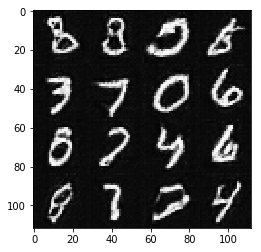

Epoch 4/4... Discriminator Loss: 1.2202... Generator Loss: 0.9222
Epoch 4/4... Discriminator Loss: 1.2350... Generator Loss: 1.0414
Epoch 4/4... Discriminator Loss: 1.2531... Generator Loss: 0.8869
Epoch 4/4... Discriminator Loss: 1.2903... Generator Loss: 0.8465
Epoch 4/4... Discriminator Loss: 1.3126... Generator Loss: 0.9539
Epoch 4/4... Discriminator Loss: 1.1881... Generator Loss: 0.7436
Epoch 4/4... Discriminator Loss: 1.2977... Generator Loss: 0.9334


In [50]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/8... Discriminator Loss: 1.9540... Generator Loss: 0.2619
Epoch 1/8... Discriminator Loss: 1.8801... Generator Loss: 0.3671
Epoch 1/8... Discriminator Loss: 1.4594... Generator Loss: 0.5926
Epoch 1/8... Discriminator Loss: 1.6050... Generator Loss: 0.3622
Epoch 1/8... Discriminator Loss: 1.8959... Generator Loss: 0.2733
Epoch 1/8... Discriminator Loss: 1.7108... Generator Loss: 0.3591
Epoch 1/8... Discriminator Loss: 1.4139... Generator Loss: 0.7129
Epoch 1/8... Discriminator Loss: 1.1472... Generator Loss: 0.6623
Epoch 1/8... Discriminator Loss: 1.4425... Generator Loss: 0.7038
Epoch 1/8... Discriminator Loss: 1.8600... Generator Loss: 0.4618


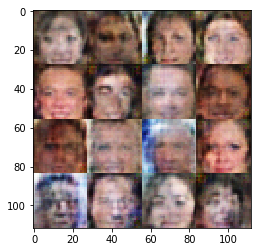

Epoch 1/8... Discriminator Loss: 1.5289... Generator Loss: 0.6313
Epoch 1/8... Discriminator Loss: 1.0820... Generator Loss: 0.5712
Epoch 1/8... Discriminator Loss: 1.5975... Generator Loss: 0.5508
Epoch 1/8... Discriminator Loss: 1.5783... Generator Loss: 0.6255
Epoch 1/8... Discriminator Loss: 1.6015... Generator Loss: 0.3762
Epoch 2/8... Discriminator Loss: 1.1235... Generator Loss: 0.8388
Epoch 2/8... Discriminator Loss: 1.4828... Generator Loss: 0.5487
Epoch 2/8... Discriminator Loss: 1.6317... Generator Loss: 0.5669
Epoch 2/8... Discriminator Loss: 1.4798... Generator Loss: 0.6887
Epoch 2/8... Discriminator Loss: 1.4788... Generator Loss: 0.6596


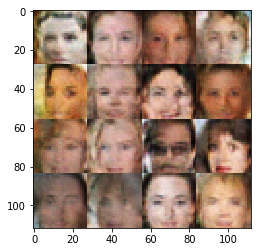

Epoch 2/8... Discriminator Loss: 1.4370... Generator Loss: 0.6439
Epoch 2/8... Discriminator Loss: 1.4655... Generator Loss: 0.6287
Epoch 2/8... Discriminator Loss: 1.4590... Generator Loss: 0.6639
Epoch 2/8... Discriminator Loss: 1.4572... Generator Loss: 0.5465
Epoch 2/8... Discriminator Loss: 1.3154... Generator Loss: 0.6370
Epoch 2/8... Discriminator Loss: 1.5512... Generator Loss: 0.8407
Epoch 2/8... Discriminator Loss: 1.3798... Generator Loss: 0.6903
Epoch 2/8... Discriminator Loss: 1.5240... Generator Loss: 0.5305
Epoch 2/8... Discriminator Loss: 1.3976... Generator Loss: 0.6444
Epoch 2/8... Discriminator Loss: 1.5176... Generator Loss: 0.5894


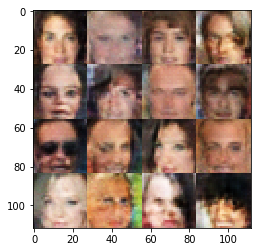

Epoch 2/8... Discriminator Loss: 1.4936... Generator Loss: 0.6829
Epoch 3/8... Discriminator Loss: 1.4863... Generator Loss: 0.6544
Epoch 3/8... Discriminator Loss: 1.4948... Generator Loss: 0.6976
Epoch 3/8... Discriminator Loss: 1.4918... Generator Loss: 0.6204
Epoch 3/8... Discriminator Loss: 1.5408... Generator Loss: 0.6078
Epoch 3/8... Discriminator Loss: 1.4733... Generator Loss: 0.6143
Epoch 3/8... Discriminator Loss: 1.4267... Generator Loss: 0.6552
Epoch 3/8... Discriminator Loss: 1.4728... Generator Loss: 0.6160
Epoch 3/8... Discriminator Loss: 1.4657... Generator Loss: 0.6164
Epoch 3/8... Discriminator Loss: 1.3591... Generator Loss: 0.8175


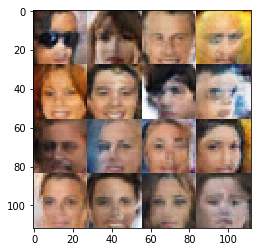

Epoch 3/8... Discriminator Loss: 1.4300... Generator Loss: 0.6102
Epoch 3/8... Discriminator Loss: 1.4877... Generator Loss: 0.6501
Epoch 3/8... Discriminator Loss: 1.4721... Generator Loss: 0.6352
Epoch 3/8... Discriminator Loss: 1.3195... Generator Loss: 1.1935
Epoch 3/8... Discriminator Loss: 1.4699... Generator Loss: 0.5807
Epoch 3/8... Discriminator Loss: 1.5163... Generator Loss: 0.6005
Epoch 3/8... Discriminator Loss: 1.4945... Generator Loss: 0.6342
Epoch 4/8... Discriminator Loss: 1.4641... Generator Loss: 0.6662
Epoch 4/8... Discriminator Loss: 1.3939... Generator Loss: 0.6496
Epoch 4/8... Discriminator Loss: 1.4524... Generator Loss: 0.7550


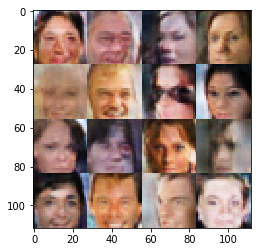

Epoch 4/8... Discriminator Loss: 1.4816... Generator Loss: 0.6643
Epoch 4/8... Discriminator Loss: 1.4437... Generator Loss: 0.6652
Epoch 4/8... Discriminator Loss: 1.4420... Generator Loss: 0.6389
Epoch 4/8... Discriminator Loss: 1.4820... Generator Loss: 0.6571
Epoch 4/8... Discriminator Loss: 1.4251... Generator Loss: 0.6899
Epoch 4/8... Discriminator Loss: 1.4460... Generator Loss: 0.6760
Epoch 4/8... Discriminator Loss: 1.4868... Generator Loss: 0.5735
Epoch 4/8... Discriminator Loss: 1.4999... Generator Loss: 0.5471
Epoch 4/8... Discriminator Loss: 1.4676... Generator Loss: 0.6322
Epoch 4/8... Discriminator Loss: 1.4299... Generator Loss: 0.6109


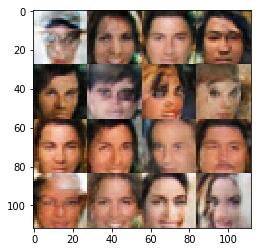

Epoch 4/8... Discriminator Loss: 1.4315... Generator Loss: 0.6765
Epoch 4/8... Discriminator Loss: 1.4344... Generator Loss: 0.6550
Epoch 4/8... Discriminator Loss: 1.5242... Generator Loss: 0.4955
Epoch 5/8... Discriminator Loss: 1.4689... Generator Loss: 0.6155
Epoch 5/8... Discriminator Loss: 1.4219... Generator Loss: 0.6617
Epoch 5/8... Discriminator Loss: 1.3958... Generator Loss: 0.6525
Epoch 5/8... Discriminator Loss: 1.4632... Generator Loss: 0.6368
Epoch 5/8... Discriminator Loss: 1.4936... Generator Loss: 0.6720
Epoch 5/8... Discriminator Loss: 1.4487... Generator Loss: 0.6425
Epoch 5/8... Discriminator Loss: 1.4310... Generator Loss: 0.6263


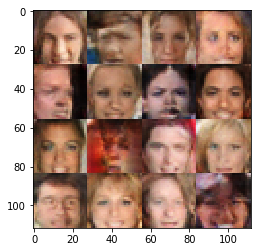

Epoch 5/8... Discriminator Loss: 1.4469... Generator Loss: 0.6679
Epoch 5/8... Discriminator Loss: 1.3975... Generator Loss: 0.6153
Epoch 5/8... Discriminator Loss: 1.3957... Generator Loss: 0.6766
Epoch 5/8... Discriminator Loss: 1.4909... Generator Loss: 0.7053
Epoch 5/8... Discriminator Loss: 1.4106... Generator Loss: 0.6645
Epoch 5/8... Discriminator Loss: 1.4388... Generator Loss: 0.6289
Epoch 5/8... Discriminator Loss: 1.4232... Generator Loss: 0.6460
Epoch 5/8... Discriminator Loss: 1.4164... Generator Loss: 0.6853
Epoch 5/8... Discriminator Loss: 1.4127... Generator Loss: 0.6410
Epoch 6/8... Discriminator Loss: 1.4406... Generator Loss: 0.6992


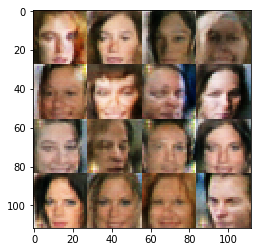

Epoch 6/8... Discriminator Loss: 1.4655... Generator Loss: 0.6254
Epoch 6/8... Discriminator Loss: 1.4654... Generator Loss: 0.6495
Epoch 6/8... Discriminator Loss: 1.4414... Generator Loss: 0.6653
Epoch 6/8... Discriminator Loss: 1.4720... Generator Loss: 0.6097
Epoch 6/8... Discriminator Loss: 1.4091... Generator Loss: 0.6233
Epoch 6/8... Discriminator Loss: 1.4129... Generator Loss: 0.6764
Epoch 6/8... Discriminator Loss: 1.4786... Generator Loss: 0.6181
Epoch 6/8... Discriminator Loss: 1.4241... Generator Loss: 0.7046
Epoch 6/8... Discriminator Loss: 1.4208... Generator Loss: 0.6452
Epoch 6/8... Discriminator Loss: 1.4121... Generator Loss: 0.6336


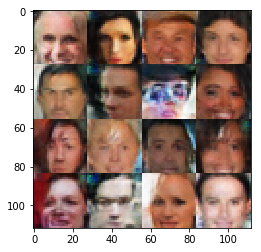

Epoch 6/8... Discriminator Loss: 1.4363... Generator Loss: 0.6960
Epoch 6/8... Discriminator Loss: 1.4106... Generator Loss: 0.6642
Epoch 6/8... Discriminator Loss: 1.4211... Generator Loss: 0.6211
Epoch 6/8... Discriminator Loss: 1.4199... Generator Loss: 0.7022
Epoch 7/8... Discriminator Loss: 1.4398... Generator Loss: 0.6929
Epoch 7/8... Discriminator Loss: 1.3893... Generator Loss: 0.6559
Epoch 7/8... Discriminator Loss: 1.4558... Generator Loss: 0.6362
Epoch 7/8... Discriminator Loss: 1.4278... Generator Loss: 0.6149
Epoch 7/8... Discriminator Loss: 1.3933... Generator Loss: 0.6835
Epoch 7/8... Discriminator Loss: 1.4471... Generator Loss: 0.6346


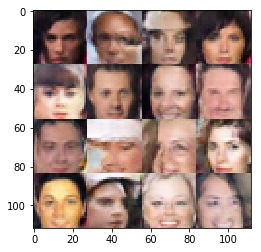

Epoch 7/8... Discriminator Loss: 1.4157... Generator Loss: 0.6825
Epoch 7/8... Discriminator Loss: 1.4058... Generator Loss: 0.6643
Epoch 7/8... Discriminator Loss: 1.4451... Generator Loss: 0.6707
Epoch 7/8... Discriminator Loss: 1.4528... Generator Loss: 0.6227
Epoch 7/8... Discriminator Loss: 1.4146... Generator Loss: 0.6548
Epoch 7/8... Discriminator Loss: 1.4034... Generator Loss: 0.6814
Epoch 7/8... Discriminator Loss: 1.3869... Generator Loss: 0.6620
Epoch 7/8... Discriminator Loss: 1.4338... Generator Loss: 0.6958
Epoch 7/8... Discriminator Loss: 1.4266... Generator Loss: 0.7085
Epoch 7/8... Discriminator Loss: 1.4542... Generator Loss: 0.6531


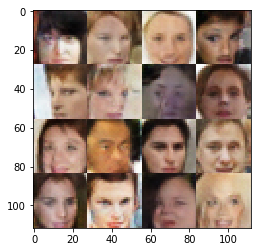

Epoch 8/8... Discriminator Loss: 1.4201... Generator Loss: 0.6774
Epoch 8/8... Discriminator Loss: 1.4099... Generator Loss: 0.6674
Epoch 8/8... Discriminator Loss: 1.4446... Generator Loss: 0.6266
Epoch 8/8... Discriminator Loss: 1.4409... Generator Loss: 0.6821
Epoch 8/8... Discriminator Loss: 1.4075... Generator Loss: 0.6672
Epoch 8/8... Discriminator Loss: 1.4394... Generator Loss: 0.7146
Epoch 8/8... Discriminator Loss: 1.3914... Generator Loss: 0.6850
Epoch 8/8... Discriminator Loss: 1.3967... Generator Loss: 0.6692
Epoch 8/8... Discriminator Loss: 1.4287... Generator Loss: 0.6888
Epoch 8/8... Discriminator Loss: 1.4058... Generator Loss: 0.6490


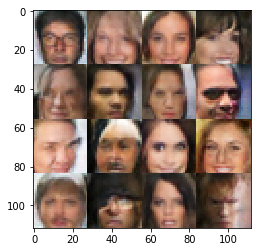

Epoch 8/8... Discriminator Loss: 1.4194... Generator Loss: 0.7029
Epoch 8/8... Discriminator Loss: 1.4367... Generator Loss: 0.6414
Epoch 8/8... Discriminator Loss: 1.3988... Generator Loss: 0.6677
Epoch 8/8... Discriminator Loss: 1.4123... Generator Loss: 0.6770
Epoch 8/8... Discriminator Loss: 1.4700... Generator Loss: 0.6366
Epoch 8/8... Discriminator Loss: 1.4468... Generator Loss: 0.6356


In [51]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Running it for 8 epochs to generate slightly realistic faces.
epochs = 8

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, show_every=1000, print_every=100)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.